In [1]:
# Tensorflow
import tensorflow as tf
print(tf.__version__)

# I/O libraries
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

# Helper libraries
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2 as cv
import IPython
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

# Comment this out if you want to see Deprecation warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

2.11.0


In [2]:
class DeepModel(object):
    """Class to load deeplab model and run inference."""

    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None

        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.compat.v1.Session(graph=self.graph)
        print("model loaded successfully")

    def run(self, image, INPUT_TENSOR_NAME = 'ImageTensor:0', OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'):
        width, height = image.size
        target_size = (2049,1025)  # size of Cityscapes images
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            OUTPUT_TENSOR_NAME,
            feed_dict={INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]  # expected batch size = 1
        if len(seg_map.shape) == 2:
            seg_map = np.expand_dims(seg_map,-1)  # need an extra dimension for cv.resize
        seg_map = cv.resize(seg_map, (width,height), interpolation=cv.INTER_NEAREST)
        return seg_map

### Visualization
Now let's create some helper functions for decoding and visualizing the results.

In [3]:
def create_label_colormap():
    colormap = np.array([
        [128,  64, 128],
        [244,  35, 232],
        [ 70,  70,  70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170,  30],
        [220, 220,   0],
        [107, 142,  35],
        [152, 251, 152],
        [ 70, 130, 180],
        [220,  20,  60],
        [255,   0,   0],
        [  0,   0, 142],
        [  0,   0,  70],
        [  0,  60, 100],
        [  0,  80, 100],
        [  0,   0, 230],
        [119,  11,  32],
        [  0,   0,   0]], dtype=np.uint8)
    return colormap


def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def vis_segmentation(image, seg_map):
    plt.figure(figsize=(20, 4))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()

def run_visualization(SAMPLE_IMAGE):
    original_im = Image.open(SAMPLE_IMAGE)
    seg_map = MODEL.run(original_im)
    vis_segmentation(original_im, seg_map)

LABEL_NAMES = np.asarray([
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

### Load the model from a frozen graph
There are two model checkpoints pre-trained on Cityscapes with different network backbones: MobileNetV2 and Xception65. We default to use MobileNetV2 for faster inference.

In [4]:
MODEL = DeepModel(r"environment_detection_and_segmentation_gt.tar.gz")

model loaded successfully


### Run on the sample image
The sample image is frame #0 in the MIT Driving Scene Segmentation (DriveSeg) Dataset.

running deeplab on the sample image...


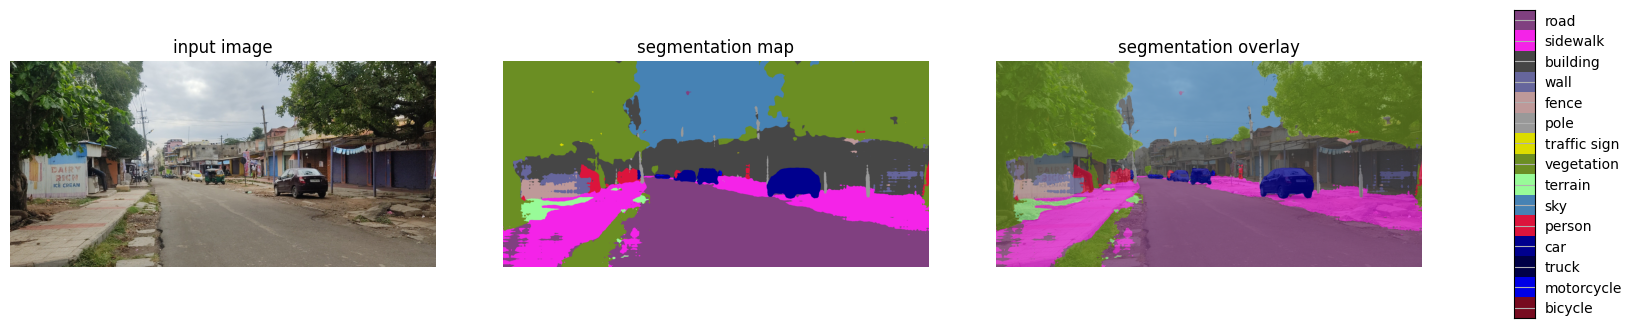

In [5]:
SAMPLE_IMAGE = r'C:\Users\sakth\PycharmProjects\pythonProject\environment detection and segmentation\test_local.jpg'
print('running deeplab on the sample image...')

run_visualization(SAMPLE_IMAGE)

### Evaluation
Now let's evaluate the model performance with the ground truth annotation. First read the annotation from a tar file.

visualizing ground truth annotation on the sample image...


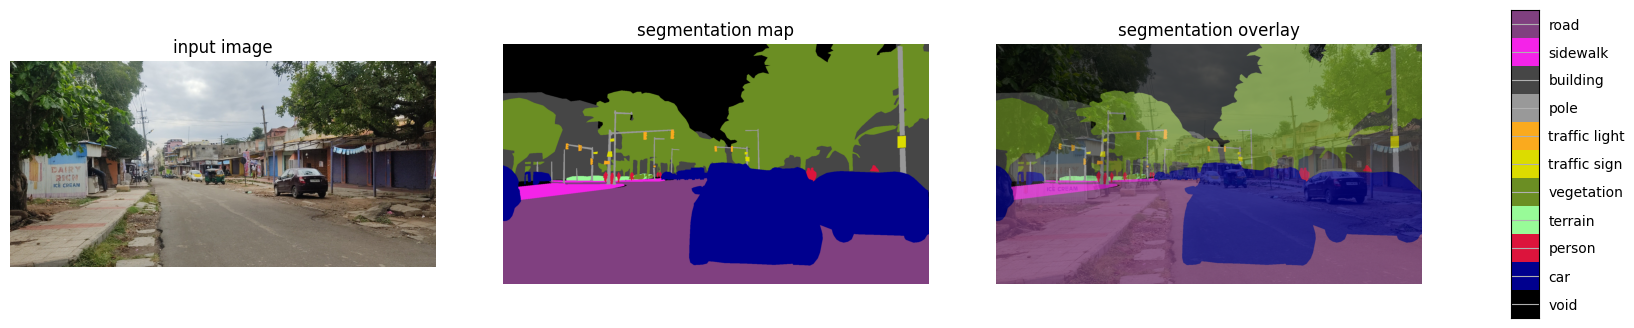

In [16]:
class DriveSeg(object):
    def __init__(self, tarball_path):
        self.tar_file = tarfile.open(tarball_path)
        self.tar_info = self.tar_file.getmembers()

    def fetch(self, index):
        tar_info = self.tar_info[index + 1]  # exclude index 0 which is the parent directory
        file_handle = self.tar_file.extractfile(tar_info)
        gt = np.fromstring(file_handle.read(), np.uint8)
        gt = cv.imdecode(gt, cv.IMREAD_COLOR)
        gt = gt[:, :, 0]  # select a single channel from the 3-channel image
        gt[gt==255] = 19  # void class, does not count for accuracy
        return gt


SAMPLE_GT = r'environment_detection_and_segmentation_gt.tar.gz'

dataset = DriveSeg(SAMPLE_GT)
print('visualizing ground truth annotation on the sample image...')

original_im = Image.open(SAMPLE_IMAGE)
gt = dataset.fetch(0)  # sample image is frame 0
# vis_segmentation(original_im, gt)

### Evaluate on the sample image
There are many ways to measure the performance of a segmentation model. The most straight forward one is pixel accuracy, which calculates how many pixels are correctly predicted. Another commonly used one is the standard Jaccard Index (intersection-over-union) as IoU = TP ⁄ (TP+FP+FN), where TP, FP, and FN are the numbers of true positive, false positive, and false negative pixels, respectively.

In [20]:
def evaluate_single(seg_map, ground_truth):
    """Evaluate a single frame with the MODEL loaded."""    
    # merge label due to different annotation scheme
    seg_map[np.logical_or(seg_map==14,seg_map==15)] = 13
    seg_map[np.logical_or(seg_map==3,seg_map==4)] = 2
    seg_map[seg_map==12] = 11

    # calculate accuracy on valid area
    acc = np.sum(seg_map[ground_truth!=19]==ground_truth[ground_truth!=19])/np.sum(ground_truth!=19)
    
    # select valid labels for evaluation
    cm = confusion_matrix(ground_truth[ground_truth!=19], seg_map[ground_truth!=19], 
                          labels=np.array([0,1,2,5,6,7,8,9,11,13]))
    intersection = np.diag(cm)
    union = np.sum(cm, 0) + np.sum(cm, 1) - np.diag(cm)
    return acc, intersection, union


print('evaluating on the sample image...')
SAMPLE_IMAGE = r'C:\Users\sakth\PycharmProjects\pythonProject\environment detection and segmentation\environment_detection_and_segmentation.png'

original_im = Image.open(SAMPLE_IMAGE)
seg_map = MODEL.run(original_im)
gt = dataset.fetch(0)  # sample image is frame 0
acc, intersection, union = evaluate_single(seg_map, gt)
class_iou = np.round(intersection / union, 5)
print('pixel accuracy: %.5f'%acc)
print('mean class IoU:', np.mean(class_iou))
print('class IoU:')
print(tabulate([class_iou], headers=LABEL_NAMES[[0,1,2,5,6,7,8,9,11,13]]))

evaluating on the sample image...
pixel accuracy: 0.90720
mean class IoU: 0.5383739999999999
class IoU:
   road    sidewalk    building     pole    traffic light    traffic sign    vegetation    terrain    person     car
-------  ----------  ----------  -------  ---------------  --------------  ------------  ---------  --------  ------
0.96126     0.34571     0.52489  0.16418          0.49512         0.52207       0.82085    0.05721   0.52215  0.9703


In [31]:
cap = cv.VideoCapture('video.mp4')

if not cap.isOpened():
    print("Error opening video file")

if not os.path.exists('images'):
    os.makedirs('images')

frame_count = 0
file_index = 0

while frame_count<30:
    ret, frame = cap.read()
    if not ret:
        break
    frame_count += 1
    print("processing frame {0}".format(frame_count))
    img = MODEL.run(Image.fromarray(frame))
    file_name = os.path.join('images', f'image{file_index:04d}.jpg') # 4-digit index
    cv.imwrite(file_name, img)
    file_index += 1
cap.release()


processing frame 1
processing frame 2
processing frame 3
processing frame 4
processing frame 5
processing frame 6
processing frame 7
processing frame 8
processing frame 9
processing frame 10
processing frame 11
processing frame 12
processing frame 13
processing frame 14
processing frame 15
processing frame 16
processing frame 17
processing frame 18
processing frame 19
processing frame 20
processing frame 21
processing frame 22
processing frame 23
processing frame 24
processing frame 25
processing frame 26
processing frame 27
processing frame 28
processing frame 29
processing frame 30


In [42]:
def vis_segmentation_stream(image, seg_map, index):
    """Visualizes segmentation overlay view and stream it with IPython display."""
    plt.figure(figsize=(12, 7))

    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.grid('off')
    plt.tight_layout()

    # Show visualization in a streaming fashion.
    f = BytesIO()
    plt.savefig(f, format='jpeg')
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    f.close()
    plt.close()

def run_visualization_video(frame, index):
    """Inferences DeepLab model on a video file and stream the visualization."""
    original_im = Image.fromarray(frame[..., ::-1])
    seg_map = MODEL.run(original_im)
    vis_segmentation_stream(original_im, seg_map, index)

SAMPLE_VIDEO = 'video.mp4'
print('running deeplab on the sample video...')

video = cv.VideoCapture(SAMPLE_VIDEO)
# num_frames = 598  # uncomment to use the full sample video
num_frames = 30

try:
    for i in range(num_frames):
        _, frame = video.read()
        if not _: break
        run_visualization_video(frame, i)
        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")

running deeplab on the sample video...


error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)
>  - imshow() missing required argument 'mat' (pos 2)


<Figure size 1200x700 with 0 Axes>